In [1]:
import numpy as np
from numpy_net import numpy_net as nn
import matplotlib.pyplot as plt  
import time
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


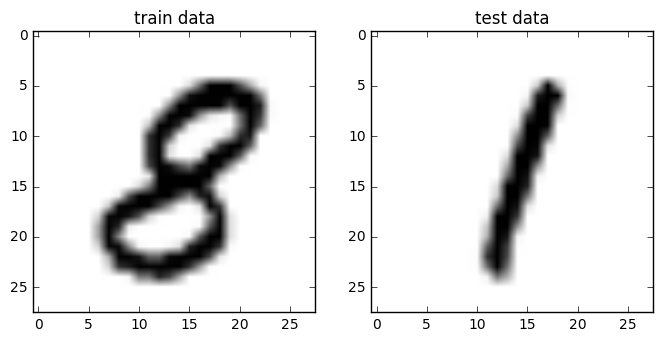

In [2]:
# Load MNIST data
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


data = mnist.train.images.reshape(55000,1,28,28)
labels = mnist.train.labels


val_data = mnist.test.images.reshape(10000,1,28,28)
val_labels = mnist.test.labels

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[5,0],cmap='Greys')
plt.title('train data')
plt.subplot(122)
plt.imshow(val_data[5,0],cmap='Greys')
plt.title('test data')
plt.show()

In [6]:
CHECK = True
stage = data[:10]

conv1 = nn.conv_layer(5,5,1,32,stride=1,padding=2)
if CHECK:
    stage = conv1.forward(stage)
    print(stage.shape,'conv1')    
relu1 = nn.function_layer(nn.f_tanh)
pool1 = nn.max_pool_layer(2)
if CHECK:
    stage = pool1.forward(stage)
    print(stage.shape,'pool1')

conv2 = nn.conv_layer(5,5,32,64,stride=1,padding=2)
if CHECK:
    stage = conv2.forward(stage)
    print(stage.shape,'conv2')
relu2 = nn.function_layer(nn.f_tanh)    
pool2 = nn.max_pool_layer(2)     #nn.max_pool_layer(2)
if CHECK:
    stage = pool2.forward(stage)
    print(stage.shape,'pool2')

flatter = nn.flatten_layer()
Lsm = nn.layer(49*64,10)
Lsm.f = nn.f_softmax


Lnan = nn.layer(49*64,1024)
Lnan.f = nn.f_tanh
Ldrop = nn.dropout_layer(1024,drop=.1)
if CHECK:
    stage = flatter.forward(stage)
    print(stage.shape,'flatter')
    stage = Lnan.forward(stage)
    print(stage.shape,'Lnan')

Lout = nn.layer(1024,10)
Lout.f = nn.f_softmax
if CHECK:
    stage = Lout.forward(stage)
    print(stage.shape,'Lout')





basemodel = nn.module([conv1,relu1,pool1,conv2,relu2,pool2,flatter,Lnan,Ldrop,Lout])
basemodel.erf = nn.bce
output = basemodel.infer(data[:10])
print(output.shape,'Model Output shape')

(10, 32, 28, 28) conv1
(10, 32, 14, 14) pool1
(10, 64, 14, 14) conv2
(10, 64, 7, 7) pool2
(10, 3136) flatter
(10, 1024) Lnan
(10, 10) Lout
(10, 10) Model Output shape


In [7]:
# reduce learning rate in all layers
for L in basemodel.Layerlist:
    try:
        L.eta *= 1e-1
        print('L')
    except:
        pass

L
L
L
L


In [5]:
print(basemodel.Layerlist)

[<numpy_net.numpy_net.conv_layer object at 0x000001604F378F28>, <numpy_net.numpy_net.function_layer object at 0x000001604F378F98>, <numpy_net.numpy_net.max_pool_layer object at 0x000001604F378F60>, <numpy_net.numpy_net.conv_layer object at 0x000001604F378EF0>, <numpy_net.numpy_net.function_layer object at 0x000001604F3710F0>, <numpy_net.numpy_net.max_pool_layer object at 0x000001604F3711D0>, <numpy_net.numpy_net.flatten_layer object at 0x000001604F371198>, <numpy_net.numpy_net.layer object at 0x000001604F371358>, <numpy_net.numpy_net.dropout_layer object at 0x000001604F3713C8>, <numpy_net.numpy_net.layer object at 0x000001604F3712E8>]


0.83 <-- acc | 25 | loss --> 0.342614172908          --- 2.876827428840625 s/batch   [0 1 7 9 7 8 3 5 2 3] / [0 1 9 4 7 9 3 5 2 3]
0.84 <-- acc | 50 | loss --> 0.458888464927          --- 2.9173009004365302 s/batch   [9 5 0 8 0 5 1 4 0 6] / [4 5 6 8 0 5 1 4 0 6]
0.89 <-- acc | 75 | loss --> 0.412873506718          --- 2.9039022729367328 s/batch   [9 3 6 6 5 1 2 7 9 5] / [9 3 6 4 5 1 2 7 9 5]
0.87 <-- acc | 100 | loss --> 0.513661239804          --- 2.8740937821066472 s/batch   [2 6 0 6 1 3 0 6 2 2] / [6 2 0 6 1 3 0 6 2 2]
0.91 <-- acc | 125 | loss --> 0.461094089416          --- 2.8610118920431704 s/batch   [1 2 6 3 7 7 3 9 5 1] / [1 2 0 3 7 7 3 9 5 1]
0.86 <-- acc | 150 | loss --> 0.468810127501          --- 2.8540545842734235 s/batch   [2 2 3 7 7 8 3 4 2 1] / [2 2 3 8 7 5 3 4 2 1]
0.88 <-- acc | 175 | loss --> 0.35943443967          --- 2.856302351345803 s/batch   [2 6 2 1 5 3 9 9 6 9] / [2 6 2 1 5 3 9 9 6 9]
0.89 <-- acc | 200 | loss --> 0.421415686572          --- 2.850276503230725

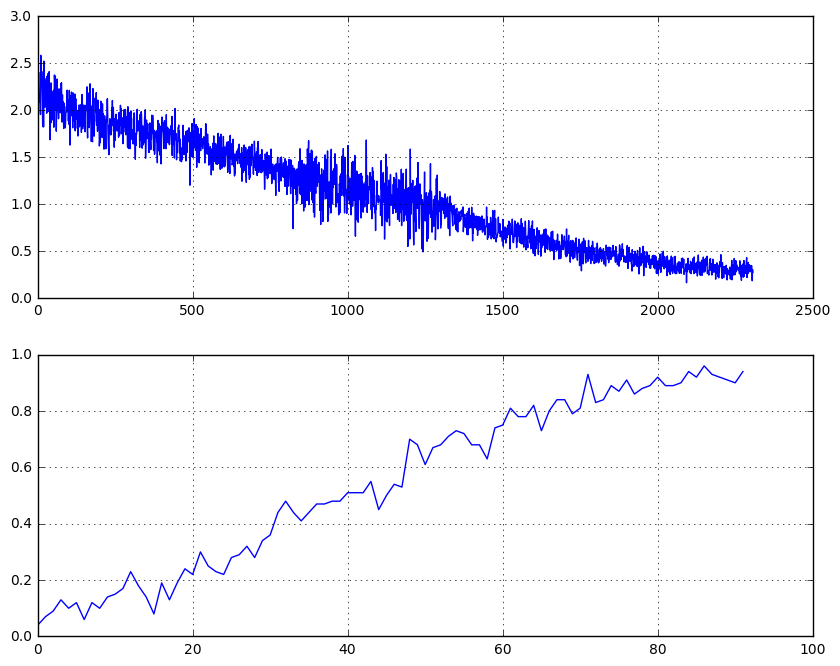

In [12]:
#losslist2 = []
#acc2 = []

starttime = time.perf_counter()
for j in range(500):
    # train with smaller batches for faster convergence and increase batchsize when finetuning (bigger batch == smaller learningrate !!)
    inds = np.random.choice(np.arange(data.shape[0]),64,replace=False)
    basemodel.train(data[inds],labels[inds])
    losslist2 += [basemodel.loss]
    #print(j, ' step ', denseNet.loss)
    #if (j+1) % 5 == 0: print(j+1)
    if (j+1) % 25 == 0:
        basemodel.Layerlist[-1].training = False
        val_inds = np.random.choice(np.arange(val_labels.shape[0]),100,replace=False)
        predictions = np.argmax(basemodel.infer(val_data[val_inds]),axis=1)
        basemodel.Layerlist[-1].training = True
        targets = np.argmax(val_labels[val_inds],axis=1)
        acc2 += [np.mean(targets == predictions)]
    if (j+1) % 25 == 0:
        print(acc2[-1], '<-- acc |',j+1,'| loss -->',losslist2[-1], '         --- {} s/batch   {} / {}'.format((time.perf_counter()-starttime)/(j+1), predictions[:10], targets[:10]))

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(range(len(losslist2)),losslist2)
plt.grid()
plt.subplot(212)
plt.plot(range(len(acc2)),acc2)
plt.grid()
plt.show()